# Traffic in a Post-Lockdown World

This project explores the traffic data provided by the [Uber Movement](https://movement.uber.com/) dataset, specifically in March 2020 when the COVID shutdown began.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)
sns.set()


from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

import warnings
from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


# **Data Cleaning**
We will look at two ways of spatial partitioning, by uniform slices and by population.
Key Vocabulary:
- Open Street Maps (OSM): IDs provided by [nodes](https://wiki.openstreetmap.org/wiki/Node)
 and [ways](https://wiki.openstreetmap.org/wiki/Way); Uber Movement uses these IDs to identify streets in the traffic speeds dataset
- Census Tracts: IDs assigned according to the US 2010 Census; Uber Movement uses these IDs to identify regions of differing travel times

## Google Plus Codes

[Google Plus Codes](https://maps.google.com/pluscodes/) divide up the world uniformly into rectangular slices

#### Load [Uber Traffic Speeds](https://movement.uber.com/explore/san_francisco/speeds/query?dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&ff=&lat.=37.7749295&lng.=-122.4370966&z.=13&lang=en-US)

In [2]:
speed_node = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')
speed_node.head(2)

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042


#### Load [Node-to-GPS Coordinates](https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz)

In [3]:
# Read OSM XML using a regex operation
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    '''
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    '''
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [4]:
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

node_ids = set(speed_node.osm_start_node_id) | set(speed_node.osm_end_node_id)

NODE_PATTERN = r"id=\"(\d+)\"\s+lat=\"(\-*\d+\.*\d*)\"\s+lon=\"(\-*\d+\.*\d*)"

node_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM, pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_gps.head(2)

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130


#### Map Traffic Speeds to GPS Coordinates and Convert to Plus Codes to Regions
Assume rectangular regions are 0.012 degrees latitudinally and longitudinally

In [5]:
# Map Traffic Speeds to GPS Coordinates
speed_gps = speed_node.merge(node_gps, left_on='osm_start_node_id', right_on='osm_node_id')

# Convert GPS Coordinates to Plus Code Regions
speed_gps['plus_latitude_idx'] = (speed_gps['Latitude'] // 0.012).astype(int) 
speed_gps['plus_longitude_idx'] = (speed_gps['Longitude'] // 0.012).astype(int)

speed_gps.head(2)

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.67528,-122.389194,3139,-10200
1,26118026,259458979,2,62.868208,26118026,37.67528,-122.389194,3139,-10200


#### Number of Plus Code Regions in San Francisco

In [6]:
num_pluscode_regions = len(speed_gps[['plus_latitude_idx', 'plus_longitude_idx']].value_counts())
num_pluscode_regions

276

### How Well Do Plus Code Regions (Clusters) Summarize Movement Speeds?
The differences between subpopulations (10.14) slightly outweigh the differences within subpopulations (8.68). Thus, plus codes may not be the most meaningful subdivider of populations as they don’t take into account demographic or traffic conditions, just uniform division by size.

In [7]:
speed_pc = speed_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']) 
avg_sd_pc = speed_pc.agg('std')['speed_mph_mean'].mean()
sd_avg_pc = speed_pc.agg('mean')['speed_mph_mean'].std()
print('Average of Standard Deviation by Plus Codes:', avg_sd_pc)
print('Standard Deviation of Average by Plus Codes:', sd_avg_pc)

Average of Standard Deviation by Plus Codes: 8.684748294968637
Standard Deviation of Average by Plus Codes: 10.13573858675904


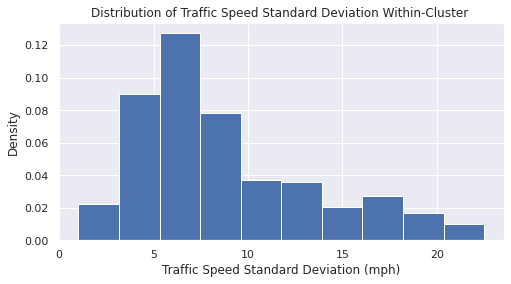

In [8]:
# Plot Histogram: Standard Deviation by Plus Codes
plt.hist(speed_pc.agg('std')['speed_mph_mean'], density=True, ec='w');
plt.title('Distribution of Traffic Speed Standard Deviation Within-Cluster ');
plt.xlabel('Traffic Speed Standard Deviation (mph)');
plt.ylabel('Density');

## Census Tract

Census tracts divide up the world based on population

#### Load [Census Tracts Geojson](https://movement.uber.com/explore/san_francisco/travel-times/query?si=1277&ti=&ag=censustracts&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=&sdn=&lat.=37.7749295&lng.=-122.4547777&z.=12&lang=en-US)
Download Data -> Geo Boundaries

In [9]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_gps = gpd.read_file(PATH_TRACTS)
tract_gps['MOVEMENT_ID'] = tract_gps['MOVEMENT_ID'].astype(int)
tract_gps.head(2)

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."


#### Map Traffic Speed to Census Tracts

In [10]:
speed_tract = (gpd.GeoDataFrame(speed_gps, geometry=gpd.points_from_xy(speed_gps.Longitude, speed_gps.Latitude))
                   .set_crs('epsg:4326').sjoin(tract_gps))

speed_tract.head(2)

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.67528,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.67528,-122.389194,3139,-10200,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"


#### Number of Census Tracts

In [11]:
num_ct = len(speed_tract.groupby('MOVEMENT_ID'))
num_ct

295

### How Well Do Census Tracts (Clusters) Summarize Movement Speeds?
The differences between (8.35) and within (8.30) subpopulations do not differ too much. Thus, census tracts are not a very effective way of creating meaningful spatial subpopulations.

In [12]:
speed_t = speed_tract.groupby('MOVEMENT_ID')
avg_sd_t = speed_t.agg('std')['speed_mph_mean'].mean()
sd_avg_t = speed_t.agg('mean')['speed_mph_mean'].std()
print('Average of Standard Deviation by Census Tracts:', avg_sd_t)
print('Standard Deviation of Average by Census Tracts:', sd_avg_t)

Average of Standard Deviation by Census Tracts: 8.300873802949297
Standard Deviation of Average by Census Tracts: 8.346122597861662


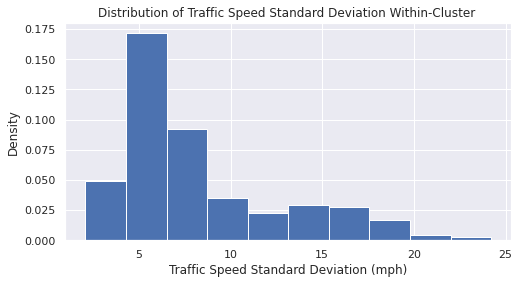

In [13]:
# Plot Histogram: Standard Deviation by Census Tracts
plt.hist(speed_t.agg('std')['speed_mph_mean'], density=True, ec='w');
plt.title('Distribution of Traffic Speed Standard Deviation Within-Cluster ');
plt.xlabel('Traffic Speed Standard Deviation (mph)');
plt.ylabel('Density');

# **EDA: Understand COVID Lockdown Impact on Traffic**

## How did lockdown affect traffic speed?
Post lockdown average speeds skew higher, with the maximum reaching 70 mph compared to almost 60 for pre-lockdown. People can drive faster with fewer cars on the road as people stay home and have less reason to commute.

### Pre-Lockdown:  March 1  - 13, 2020

In [14]:
speed_pre = (speed_tract[speed_tract['day'] < 14].groupby('MOVEMENT_ID', as_index=False).mean()
                        .merge(tract_gps)[['DISPLAY_NAME', 'geometry', 'speed_mph_mean']])
speed_pre.head(2)

,DISPLAY_NAME,geometry,speed_mph_mean
0,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",14.585102
1,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",15.679922


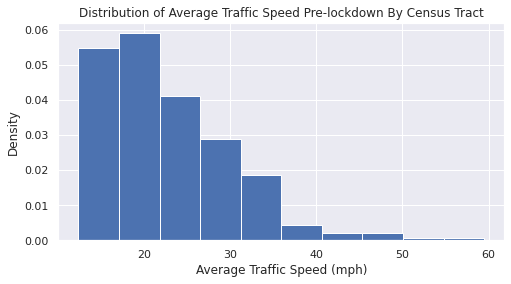

In [15]:
plt.hist(speed_pre['speed_mph_mean'], density=True, ec='w');
plt.title('Distribution of Average Traffic Speed Pre-lockdown By Census Tract');
plt.xlabel('Average Traffic Speed (mph)');
plt.ylabel('Density');

#### Census Tracts with the Lowest Average Traffic Speeds

In [16]:
speed_pre_low = speed_pre.sort_values('speed_mph_mean').iloc[0:5, :]
speed_pre_low

,DISPLAY_NAME,geometry,speed_mph_mean
166,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",12.417079
249,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107...",12.595120
163,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",12.945291
59,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",13.195865
51,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182...",13.490311


#### Census Tracts with the Highest Average Traffic Speeds

In [17]:
speed_pre_high = speed_pre.sort_values('speed_mph_mean', ascending = False).iloc[:5,:]
speed_pre_high

,DISPLAY_NAME,geometry,speed_mph_mean
23,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161...",59.498552
36,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",53.867847
155,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185...",47.318340
248,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",47.225137
199,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",45.492292


### Post-Lockdown: March 14 - 31, 2020

In [18]:
speed_pos = (speed_tract[speed_tract['day'] >= 14].groupby('MOVEMENT_ID', as_index=False).mean()
                        .merge(tract_gps)[['DISPLAY_NAME', 'geometry', 'speed_mph_mean']])
speed_pos.head(2)

,DISPLAY_NAME,geometry,speed_mph_mean
0,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",16.143154
1,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",16.871488


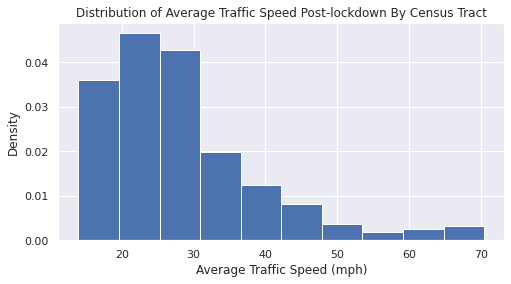

In [19]:
plt.hist(speed_pos['speed_mph_mean'], density=True, ec='w');
plt.title('Distribution of Average Traffic Speed Post-lockdown By Census Tract');
plt.xlabel('Average Traffic Speed (mph)');
plt.ylabel('Density');

#### Census Tracts with the Lowest Average Traffic Speeds

In [20]:
speed_pos_low = speed_pos.sort_values('speed_mph_mean').iloc[0:5, :]
speed_pos_low

,DISPLAY_NAME,geometry,speed_mph_mean
159,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",13.947161
162,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",14.157774
56,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",14.355647
100,"2600 Broadway, Pacific Heights, San Francisco","MULTIPOLYGON (((-122.44673 37.79471, -122.4402...",14.960722
101,"2100 Divisadero Street, Pacific Heights, San F...","MULTIPOLYGON (((-122.44612 37.79100, -122.4394...",15.219232


#### Census Tracts with the Highest Average Traffic Speeds

In [21]:
speed_pos_high = speed_pos.sort_values('speed_mph_mean', ascending = False).iloc[:5,:]
speed_pos_high

,DISPLAY_NAME,geometry,speed_mph_mean
139,"0 Colorados Drive, Millbrae","MULTIPOLYGON (((-122.41304 37.59217, -122.4139...",70.464594
225,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710...",69.823830
195,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",67.013959
241,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",66.958324
34,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",65.053061


### Change in Traffic Speed

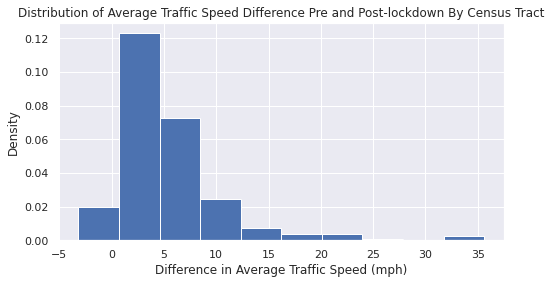

In [22]:
pre_post = speed_pre.merge(speed_pos, on='DISPLAY_NAME') \
          .rename(columns={'speed_mph_mean_x': 'speed_mph_mean_pre', 
                           'speed_mph_mean_y': 'speed_mph_mean_post',
                           'geometry_x': 'geometry'}) \
          .drop(columns=['geometry_y'])
differences = pre_post['speed_mph_mean_post'] - pre_post['speed_mph_mean_pre']

# Plot Histograme: Differences
plt.hist(differences, density=True, ec='w');
plt.title('Distribution of Average Traffic Speed Difference Pre and Post-lockdown By Census Tract');
plt.xlabel('Difference in Average Traffic Speed (mph)');
plt.ylabel('Density');

### Average Speed by Day
The change in speed increases gradually until March 16, 2020, where it had a sharp increase between the 16th and 17th and continued to increase gradually. After implementing shelter-in-place on the 16th, nearly 7 million residents had to restrict activities, leading to fewer people on the road (ABC news).  With fewer people, there was less traffic, and people could drive faster, which resulted in the jump in average speed.

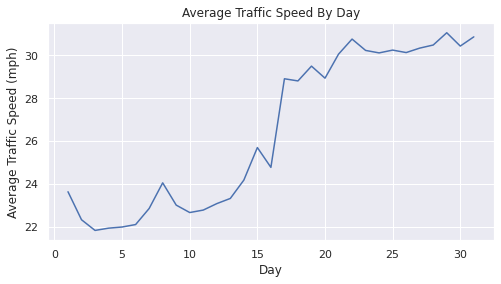

In [23]:
speeds_daily = speed_tract.groupby('day').agg('mean')['speed_mph_mean']
plt.plot(speeds_daily.index.values, speeds_daily);
plt.title('Average Traffic Speed By Day');
plt.xlabel('Day');
plt.ylabel('Average Traffic Speed (mph)');

### Correlations
The correlation for pre-lockdown and differences is lower than for post-lockdown, despite both being positive. The correlation for pre-lockdown is lower because more cars were on the road during that time, leading to higher differences from more variability between pre-lockdown speeds and differences. The correlation for post-lockdown is higher due to less traffic from fewer cars. Thus, there are fewer differences to calculate, and the variability between pre-lockdown speeds and differences is lower.

In [24]:
corr_pre_diff = np.corrcoef(pre_post['speed_mph_mean_pre'], differences)[0][1]
corr_pos_diff = np.corrcoef(pre_post['speed_mph_mean_post'], differences)[0][1]
print('Correlation Between Pre-Lockdown  and Change in Average Speeds:', corr_pre_diff)
print('Correlation Between Post-Lockdown and Change in Average Speeds:', corr_pos_diff)

Correlation Between Pre-Lockdown  and Change in Average Speeds: 0.4633006380580186
Correlation Between Post-Lockdown and Change in Average Speeds: 0.7926799984780658


## What traffic areas were impacted by lockdown?
#### Spatial Heatmap (Left): Pre-Lockdown Average Traffic Speed per Census Tract
Most areas with low traffic speeds (0-25 mph) are located within the center of San Francisco (Union Square, Financial District), which is densely populated and has narrow, complicated streets. Cars have difficulty moving when there are a lot of pedestrians and other vehicles, which is why San Francisco has a lower average lower traffic speed. 
#### Spatial Heatmap (Right): Change in Average Daily Speeds Pre vs. Post Lockdown
Hillsborough, a residential town, had the most drastic increase in average speed (~35mph) from pre-lockdown. With fewer people going out and no cars around, people are more likely to drive faster than before. San Fransisco had little impact due to the unchangeable characteristics of the city, such as complicated road systems and steep hills. People still have to stop at the numerous traffic lights and stop signs, driver slower on hills, and the city remains densely populated.

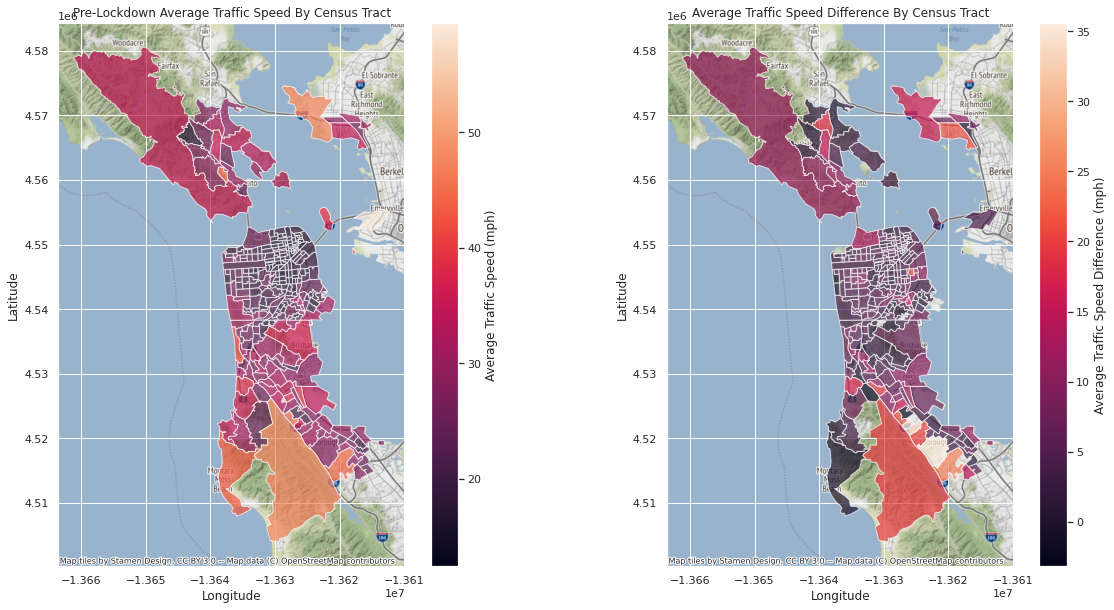

In [25]:
pre_post['differences'] = differences

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
cx.add_basemap(speed_pre.to_crs(epsg=3857).plot(column='speed_mph_mean', 
               legend_kwds={'label': 'Average Traffic Speed (mph)'}, 
               legend=True, alpha=0.7, figsize=(10, 10), ax=axs[0]));
cx.add_basemap(gpd.GeoDataFrame(pre_post).to_crs(epsg=3857).plot(column='differences', 
               legend_kwds={'label': 'Average Traffic Speed Difference (mph)'}, 
               legend=True, alpha=0.7, figsize=(10, 10), ax=axs[1]));
axs[0].set(title='Pre-Lockdown Average Traffic Speed By Census Tract',
           xlabel='Longitude', ylabel='Latitude');
axs[1].set(title='Average Traffic Speed Difference By Census Tract',
           xlabel='Longitude', ylabel='Latitude');

# **EDA: Understand Lockdown Impact on Travel Times**
How were travel times impacted using the origin as 300 Hayes Street and traveling to other destinations?

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## Load [Travel Times](https://movement.uber.com/explore/san_francisco/travel-times/query?si=1277&ti=&ag=censustracts&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=&sdn=&lang=en-US)

- Which routes from Hayes Valley had a similar impact on travel time? Did they share any factors in common (same place or similar areas)?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [26]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
time_tract = pd.read_csv(PATH_TIMES)
time_tract.head(2)

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1


### Average Travel Time
Most travel times fall around 1300 seconds or about 20 minutes. The distribution is right-skewed, indicating that most destinations are close to the origin or have shorter travel times.

In [27]:
# Average Travel Time By Cluster
mean_time = time_tract[['Destination Movement ID', 'day', 'Mean Travel Time (Seconds)', 'Destination Display Name']]
mean_time.groupby('Destination Movement ID', as_index=False).mean()['Mean Travel Time (Seconds)'].describe()

count     601.000000
mean     1363.997320
std       756.228731
min        78.709677
25%       791.935484
50%      1246.125000
75%      1878.117647
max      3755.000000
Name: Mean Travel Time (Seconds), dtype: float64

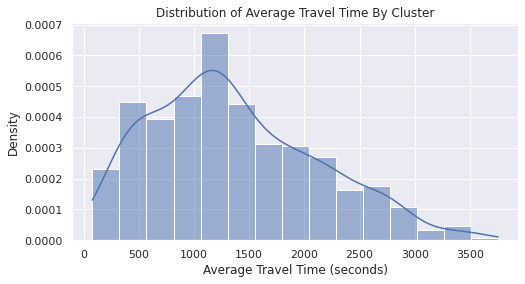

In [28]:
# Plot Histogram: Average Travel Time
sns.histplot(mean_time.groupby('Destination Movement ID', as_index=False).mean(),
             x='Mean Travel Time (Seconds)', stat='density', kde=True);
plt.title('Distribution of Average Travel Time By Cluster');
plt.xlabel('Average Travel Time (seconds)');

### Pre vs Post-Lockdown Average Travel Time
From the comparison plot below, the post-lockdown travel time distribution has a shorter right tail than the pre-lockdown distribution. Travel times generally shorten from pre to post-lockdown.

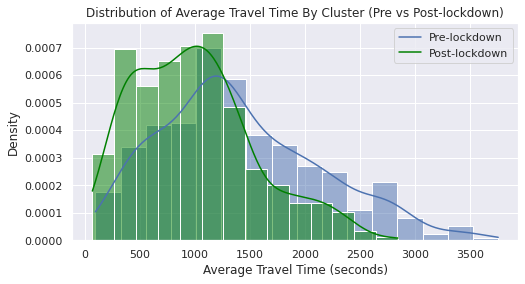

In [29]:
# Pre vs Post-lockdown
pre_time = mean_time[mean_time['day'] < 14].groupby('Destination Movement ID', as_index=False).mean()
pos_time = mean_time[mean_time['day'] >= 14].groupby('Destination Movement ID', as_index=False).mean()

# Plot Histogram: Pre vs Post Average Travel Time
sns.histplot(pre_time, x='Mean Travel Time (Seconds)', stat='density', kde=True);
sns.histplot(pos_time, x='Mean Travel Time (Seconds)', stat='density', kde=True, color='green');
plt.title('Distribution of Average Travel Time By Cluster (Pre vs Post-lockdown)');
plt.xlabel('Average Travel Time (seconds)');
plt.legend(labels=['Pre-lockdown','Post-lockdown']);

### Change in Travel Time by Census Tract

On average, travel time decreased after enforcing COVID lockdown.

In [30]:
# Difference by Cluster
pre_pos_time = (pre_time.merge(pos_time, on='Destination Movement ID') 
          .rename(columns={'Mean Travel Time (Seconds)_x': 'Mean Travel Time (Seconds)_pre', 
                           'Mean Travel Time (Seconds)_y': 'Mean Travel Time (Seconds)_post',
                           'day_x': 'day_pre', 'day_y': 'day_post'}) 
          .merge(time_tract[['Destination Movement ID', 'Destination Display Name']]) 
          .drop_duplicates())
pre_pos_time['post-pre diff'] = pre_pos_time['Mean Travel Time (Seconds)_post'] - pre_pos_time['Mean Travel Time (Seconds)_pre']
pre_pos_time['post-pre diff'].describe()

count    444.000000
mean    -163.334810
std      117.449789
min     -684.111111
25%     -226.329808
50%     -164.886447
75%     -109.502137
max      389.256410
Name: post-pre diff, dtype: float64

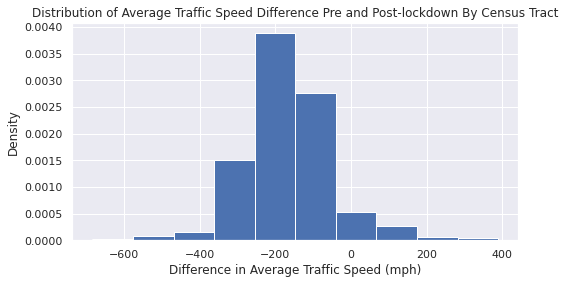

In [31]:
# Plot Histogram: Change
plt.hist(pre_pos_time['post-pre diff'], density=True, ec='w');
plt.title('Distribution of Average Traffic Speed Difference Pre and Post-lockdown By Census Tract');
plt.xlabel('Difference in Average Traffic Speed (mph)');
plt.ylabel('Density');

#### Census Tracts with Increased Average Travel Time From Pre-Lockdown

In [32]:
inc_time = pre_pos_time.sort_values('post-pre diff', ascending = False).iloc[:10, 5:]
inc_time

,Destination Display Name,post-pre diff
2604,"Building F, Buckingham Way, Lakeshore, San Fra...",389.256410
3540,"2900 Willow Road, San Pablo",283.833333
7730,"0 Waterbury Lane, Novato",277.000000
2732,"200 Oriente Street, Bayshore Heights, Daly City",215.282051
7733,"2500 Lucas Valley Road, San Rafael",205.666667
8686,"500 Fairway Drive, Novato",174.000000
1607,"0 Oak Gate Place, Pleasant Hill",167.400000
4217,"Saint Vincents Drive, San Rafael",147.200000
1285,"800 Pine Lane, San Rafael",145.600000
805,"0 El Pavo Real Circle, San Rafael",139.142857


#### Census Tracts with Decreased Average Travel Time From Pre-Lockdown

In [33]:
dec_time = pre_pos_time.sort_values('post-pre diff').iloc[:10, 5:]
dec_time

,Destination Display Name,post-pre diff
7636,"1100 East Arques Avenue, Sunnyvale",-684.111111
5180,"Tasman Drive, Santa Clara",-520.076923
1915,"200 2nd Street, Sunnyvale",-501.205128
7876,"1000 Liege Terrace, Morse Park, Sunnyvale",-483.153846
990,"200 Silverlake Drive, Lakewood, Sunnyvale",-471.750000
401,"400 West Sunset Boulevard, Hayward",-454.714286
9244,"1200 Elko Drive, Sunnyvale",-453.583333
7646,"500 Logue Avenue, Mountain View",-442.107692
1931,"500 Aldo Avenue, Santa Clara",-438.375000
4195,"15500 Tracy Street, San Lorenzo",-422.000000


## What traffic areas were impacted by lockdown?
#### Spatial Heatmap (Left): Pre-Lockdown Average Travel Time per Census Tract
Travel time generally increases as the distance from the origin increases.
#### Spatial Heatmap (Right): Change in Average Travel Time Pre vs. Post Lockdown
Travel time increased for areas near or north of San Francisco. Travel time decreased the most for areas far or south of San Francisco.

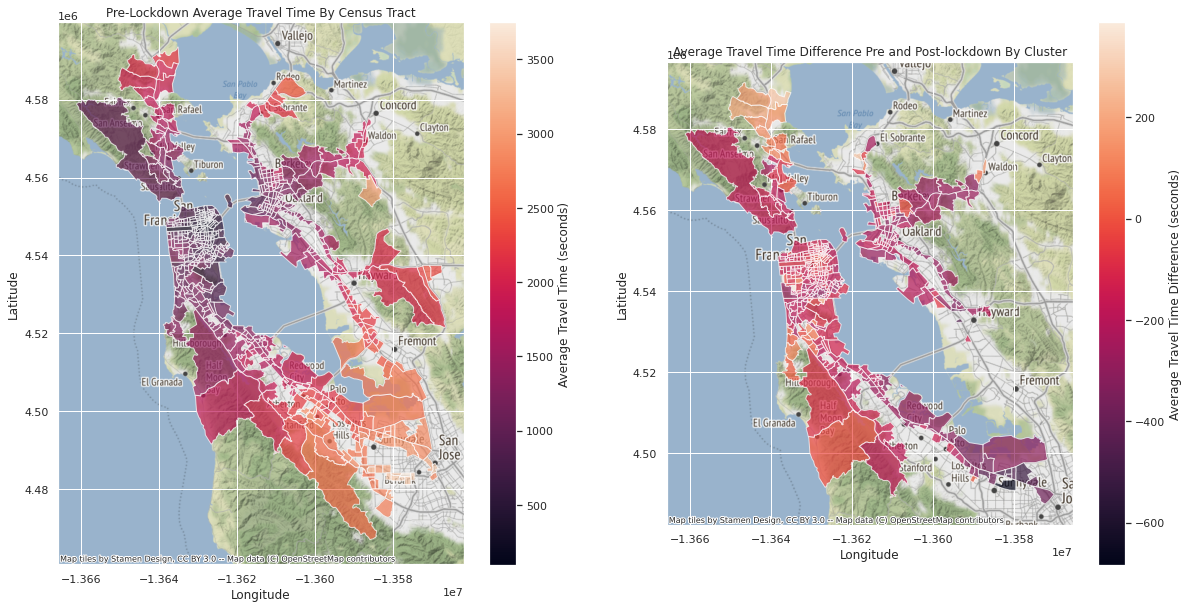

In [34]:
pre_time_geo = (gpd.GeoDataFrame(pre_time)
                   .merge(tract_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
                   .set_crs('epsg:4326'))
pre_pos_time_geo = (gpd.GeoDataFrame(pre_pos_time)
                       .merge(tract_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
                       .set_crs('epsg:4326'))

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
cx.add_basemap(pre_time_geo.to_crs(epsg=3857).plot(column='Mean Travel Time (Seconds)', 
               legend_kwds={'label': 'Average Travel Time (seconds)'}, 
               legend=True, alpha=0.7, figsize=(10, 10), ax=axs[0]));
cx.add_basemap(pre_pos_time_geo.to_crs(epsg=3857).plot(column='post-pre diff', 
               legend_kwds={'label': 'Average Travel Time Difference (seconds)'}, 
               legend=True, alpha=0.7, figsize=(10, 10), ax=axs[1]));
axs[0].set(title='Pre-Lockdown Average Travel Time By Census Tract',
           xlabel='Longitude', ylabel='Latitude');
axs[1].set(title='Average Travel Time Difference Pre and Post-lockdown By Cluster',
           xlabel='Longitude', ylabel='Latitude');

## Was Travel Time Impacted for Each Day of the Week?
Travel time experienced more change on weekdays than on weekends, likely due to people working from home and no longer needing to drive to work. Empty roads replaced traffic congestion during rush hours on the weekdays when the state ordered a shelter in place. Weekend traffic is consistent throughout the day, so travel time did not change much.

In [35]:
# Average Travel Time By Day of the Week
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
time_tract['day_of_week'] = (time_tract[['day']] % 7).replace([1, 2, 3, 4, 5, 6, 0], days)
by_day = (time_tract.groupby(['Destination Movement ID', 'day_of_week'], as_index=False).mean()
          [['Destination Movement ID', 'day_of_week', 'Mean Travel Time (Seconds)']]
          .groupby('day_of_week', as_index=False).mean().set_index('day_of_week').reindex(days))

# Difference by Day
pre_day = time_tract[time_tract['day'] < 14] \
          [['Destination Movement ID', 'Mean Travel Time (Seconds)', 'day_of_week']] \
          .groupby(['Destination Movement ID', 'day_of_week'], as_index=False).mean()
post_day = time_tract[time_tract['day'] >= 14] \
           [['Destination Movement ID', 'Mean Travel Time (Seconds)', 'day_of_week']] \
           .groupby(['Destination Movement ID', 'day_of_week'], as_index=False).mean()
pre_post_day = pre_day.merge(post_day, on=['Destination Movement ID', 'day_of_week']) \
          .rename(columns={'Mean Travel Time (Seconds)_x': 'Mean Travel Time (Seconds)_pre', 
                           'Mean Travel Time (Seconds)_y': 'Mean Travel Time (Seconds)_post'}) \
          .merge(time_tract[['Destination Movement ID', 'Destination Display Name']]) \
          .drop_duplicates()
pre_post_day['post-pre diff'] = pre_post_day['Mean Travel Time (Seconds)_post'] - pre_post_day['Mean Travel Time (Seconds)_pre']
diff_day = pre_post_day.groupby('day_of_week', as_index=False).mean().set_index('day_of_week').reindex(days)
pre_post_day['change'] = pre_post_day['post-pre diff'] / pre_post_day['Mean Travel Time (Seconds)_pre']

pre_post_day['week'] = (pre_post_day['day_of_week']
                        .replace({'Sunday': 'Weekend', 'Saturday': 'Weekend', 
                                  'Monday':'Weekday', 'Tuesday': 'Weekday', 
                                  'Wednesday': 'Weekday', 'Thursday': 'Weekday', 
                                  'Friday': 'Weekday'}))
# Extract City Names
# pre_post_day['city'] = pre_post_day['Destination Display Name'].str.split(', ').str[-1]

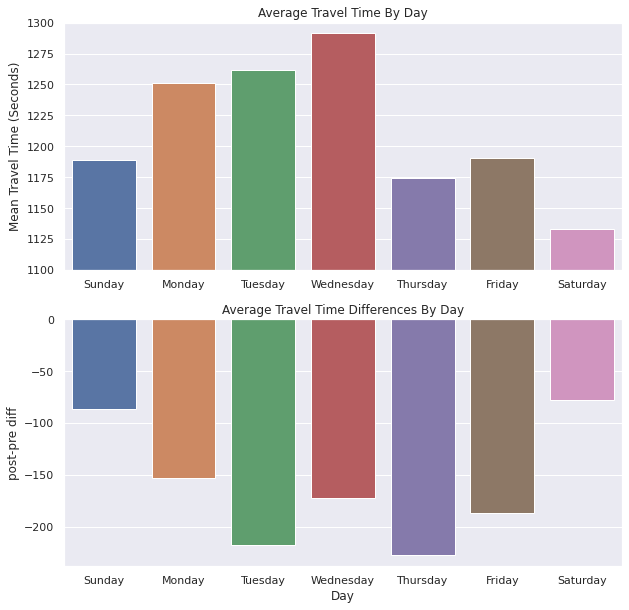

In [36]:
# Plot Histogram: Average Travel Time and Differences by Day
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
sns.barplot(x=by_day.index.values, y='Mean Travel Time (Seconds)', data=by_day, ax=axs[0]);
sns.barplot(x=diff_day.index.values, y='post-pre diff', data=diff_day, ax=axs[1]);

axs[0].set(title='Average Travel Time By Day', ylim=(1100, 1300));
axs[1].set(title='Average Travel Time Differences By Day', xlabel='Day');

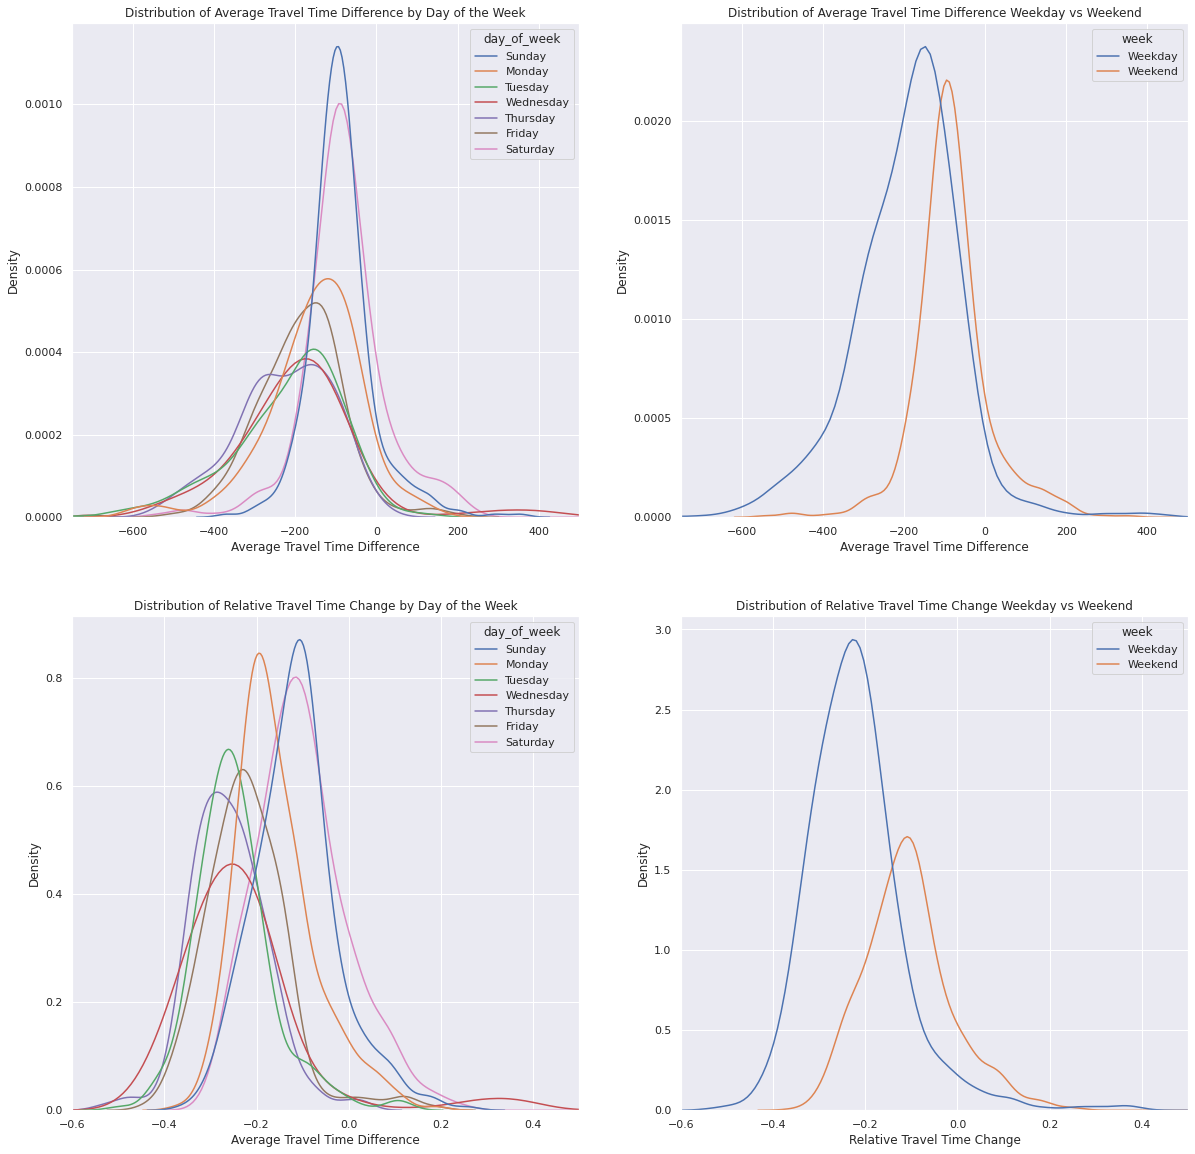

In [37]:
# Plot KDE: Travel Time by Day
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
sns.kdeplot(data=pre_post_day, hue='day_of_week', hue_order=days, x='post-pre diff', ax=axs[0, 0]);
sns.kdeplot(data=pre_post_day, hue='week', x='post-pre diff', ax=axs[0, 1]);
sns.kdeplot(data=pre_post_day, hue='day_of_week', hue_order=days, x='change', ax=axs[1, 0]);
sns.kdeplot(data=pre_post_day, hue='week', x='change', ax=axs[1, 1]);

axs[0, 0].set(title='Distribution of Average Travel Time Difference by Day of the Week', 
           xlabel='Average Travel Time Difference', xlim=(-750, 500));
axs[0, 1].set(title='Distribution of Average Travel Time Difference Weekday vs Weekend', 
           xlabel='Average Travel Time Difference', xlim=(-750, 500));
axs[1, 0].set(title='Distribution of Relative Travel Time Change by Day of the Week', 
           xlabel='Average Travel Time Difference', xlim=(-0.6, 0.5));
axs[1, 1].set(title='Distribution of Relative Travel Time Change Weekday vs Weekend', 
           xlabel='Relative Travel Time Change', xlim=(-0.6, 0.5));

# Modeling: Predict Traffic Speeds Post-Lockdown

## Predict Daily Traffic Speed on Pre-Lockdown Data

Predict daily traffic speed per census tract, given the previous $k=5$ days' traffic speeds. Each sample includes speed averages from the previous 5 days for each census track.

In [38]:
def dataframe_to_time_series(df: pd.DataFrame):
    '''Convert dataframe into a 'time series'.
    
    :param df: original dataframe, mapping speeds to census tracts.
               contains the 'MOVEMENT_ID', 'day', and 'speed_mph_mean'
    :return: new dataframe with dimensions n x d, where
        n: number of samples (census tracts)
        d: number of dimensions (days)
        values are the speeds
    '''
    return df[['day', 'speed_mph_mean', 'MOVEMENT_ID']].groupby(['MOVEMENT_ID', 'day']).mean().unstack()

def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    '''Convert 'time series' into train-validate splits, in numpy
    Assume dataframe contains a 'day' column starting from 1 and are consecutive.
    
    :param df: dataframe with dimensions n x d
        n: number of samples (census tracts)
        d: number of dimensions (days)
        values are the speeds
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    '''
    X_train = pd.DataFrame()
    for t in np.arange(df.shape[1]-T-n_val):
        x_t = df.iloc[:, t:t+T].values
        X_train = pd.concat([X_train, pd.DataFrame(x_t)])
        
    X_val = pd.DataFrame()
    for t in np.arange(df.shape[1]-T-n_val, df.shape[1]-T):
        x_v = df.iloc[:, t:t+T].values
        X_val = pd.concat([X_val, pd.DataFrame(x_v)])
        
    y_train = df.iloc[:, T:df.shape[1]-n_val].to_numpy().T.flatten()
    y_val = df.iloc[:, df.shape[1]-n_val:].to_numpy().T.flatten()
    
    return X_train.to_numpy(), y_train, X_val.to_numpy(), y_val

def remove_nans(X: np.array, y: np.array):
    '''Remove all nans from the provided (X, y) pair.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return:  (X, y)
    '''
    if not len(X):
        return X,y
    df = pd.DataFrame(X)
    df['y'] = y
    df = df.dropna()
    return df.iloc[:, :X.shape[1]].to_numpy(), df.iloc[:, X.shape[1]].to_numpy()

def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    '''Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above 'time_series_to_numpy' and 'remove_nans'
    
    For description of arguments, see 'time_series_to_numpy' docstring.
    '''
    answer = time_series_to_numpy(time_series, T, n_val)
    train = remove_nans(answer[0], answer[1])
    val = remove_nans(answer[2], answer[3])
    return train[0], train[1], val[0], val[1]

### Train and Evaluate a Linear Model on Pre-Lockdown Data
Train a linear model that forecasts the next day's speed average using training dataset, X_train and y_train. Predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$: daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$: vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$

Evaluate model on validation dataset X_val and y_val

Score: 0.963923292212207


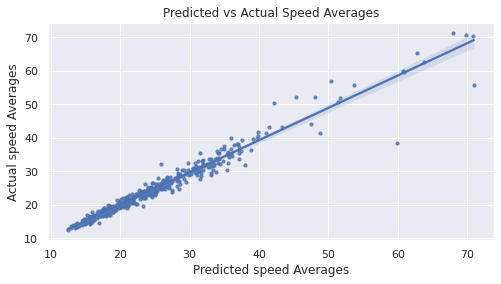

In [39]:
time_series = dataframe_to_time_series(speed_tract)
time_series_pre = time_series.iloc[:, list(range(13))]
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)
# X_train.shape, y_train.shape, X_val.shape, y_val.shape
# time_series.head(2)
# time_series_pre.head(2)

reg = LinearRegression().fit(X_train, y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score
print('Score:', score)

# Plot Scatter: predicted averages against ground truth averages
sns.regplot(x=reg.predict(X_val), y=y_val, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages');
plt.xlabel('Predicted speed Averages');
plt.ylabel('Actual speed Averages');

## Understand Failures on Post-Lockdown Data

Since the dataset is distributed spatially and temporally, the most intuitive spaces to visualize model errors or performances are spatially and temporally. So, where does the model fail?

### Evaluate on Post-Lockdown Data

Evaluate post-lockdown data for all census tracts using reg from previously

Score: 0.9337122097376673


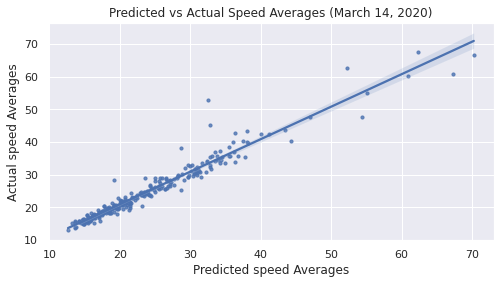

In [40]:
# get 'time series' dataframe for days 9, 10, 11, 12, 13
# get 'time series' dataframe for 14th
time_series_x_pre, time_series_y_post, X_val_post, y_val_post = time_series_to_dataset(time_series.iloc[:, 8:14], 5, 0)
score_pre_14th = reg.score(time_series_x_pre, time_series_y_post)
print('Score:', score_pre_14th)
#Plot Scatter: predicted averages against ground truth averages
sns.regplot(x=reg.predict(time_series_x_pre), y=time_series_y_post, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages (March 14, 2020)');
plt.xlabel('Predicted speed Averages');
plt.ylabel('Actual speed Averages');

### Report Model Performance Temporally
From the line graph below, the lowest point was on March 17th with a model performance of 0.7248. According to the [Covid timeline in the Bay Area](https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/), shelter in place was enacted on the 17th, severely restricting travel, so speed data from the days prior wouldn't be able to predict this external policy. Model performances began to worsen on the 15th when Newsom ordered elderlies to stay home and reduce restaurant capacity. This would again affect traffic beyond what just looking at previous days' speeds could predict. The dip in performance on March 8th is foreshadowed in the speeds_daily plot where there is a sudden spike in average speed, which probably caused the model accuracy to decrease. The model miraculously recovers possibly because of the sudden increase in average speed on the 8th declining back to its 'normal' state. Without the spike, there seems to be a gradual increase in traffic speed between the 5th and the 10th.

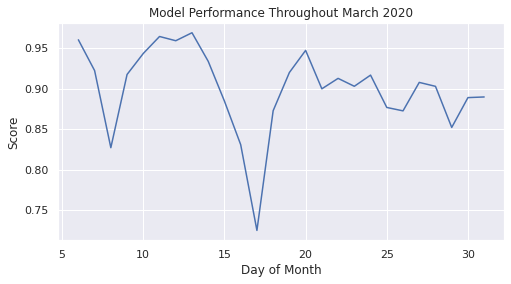

In [41]:
scores = []
for i in np.arange(5, 31):
    prev_five = time_series.iloc[:, i-5:i+1].dropna()
    x_pre_mar = prev_five.iloc[:, :5] 
    y_post_mar = prev_five.iloc[:, 5]
    scr = reg.score(x_pre_mar, y_post_mar)
    scores += [scr]

# Plot Line: performance of the original model throughout all of March 2020.
plt.plot(np.arange(6, 32), scores)
plt.title('Model Performance Throughout March 2020');
plt.xlabel('Day of Month');
plt.ylabel('Score');

Score: 0.7248438392437913


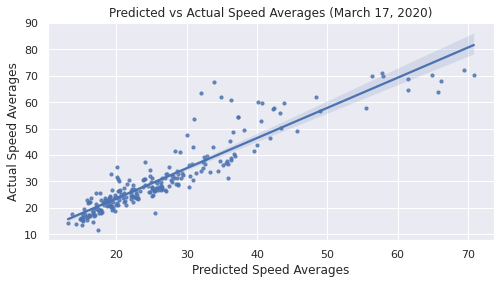

In [42]:
time_series_x_pre_17 = time_series_to_dataset(time_series.iloc[:, 11:17], 5, 0)[0]
time_series_y_post_17 = time_series_to_dataset(time_series.iloc[:, 11:17], 5, 0)[1]
score_17 = reg.score(time_series_x_pre_17, time_series_y_post_17)
print('Score:', score_17) # not high

# Plot Scatter: predicted averages against ground truth averages for model predictions on March 17th
sns.regplot(x=reg.predict(time_series_x_pre_17), y=time_series_y_post_17, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages (March 17, 2020)');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');

## ‘Fix’ Model on Post-Lockdown Data

### Learn Delta Off of a Moving Bias

Since the average speed, shown in the EDA, increases sharply, we learn delta around the average and naively assume that the average of day $t$ is the average for day $t+1$.

The delta model is much more effective for the 17th compared to the previous one. By predicting changes in velocity after subtracting the daily average speeds, we avoid including the drastic speed change when lockdown restrictions were imposed that paralyzed the dataset's ability to predict speed based on previous days for the period when restrictions were first enforced (15-17th, etc.). By subtracting daily average speeds, we normalize the data so that pre and post-lockdown speed deltas are more consistent with one another, making the model more effective even when the drastic change in average speed occurs.

In [43]:
time_series_delta = time_series_pre - np.array(speeds_daily.iloc[:13]) # subtract daily average from pre-lockdown 'time series' dataframe 'time_series_pre'
time_series_delta.head(2)

speed_mph_mean                                                    \
day                     1         2         3         4         5         6    
MOVEMENT_ID                                                                    
9                -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20               -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   

                                                                         \
day                7         8         9         10        11        12   
MOVEMENT_ID                                                               
9           -7.342673 -7.838718 -8.163539 -7.950124 -9.037052 -8.687048   
20          -5.762984 -5.960594 -6.830754 -7.366163 -8.139844 -8.795882   

                       
day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074

Score: 0.9645254590172871


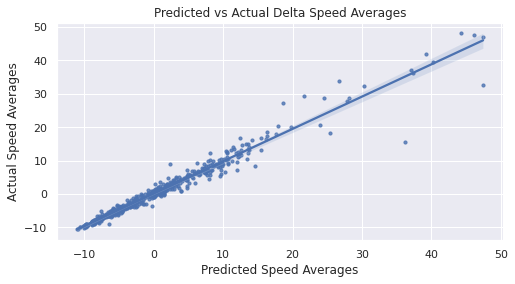

In [44]:
# Evaluate model on pre-lockdown data
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)
res = reg_delta.score(X_delta_val, y_delta_val)
print('Score:', res)

# Plot Scatter: 
sns.regplot(x=reg.predict(X_delta_val), y=y_delta_val, scatter_kws={'s':10});
plt.title('Predicted vs Actual Delta Speed Averages');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');

Score: 0.8346539614612525


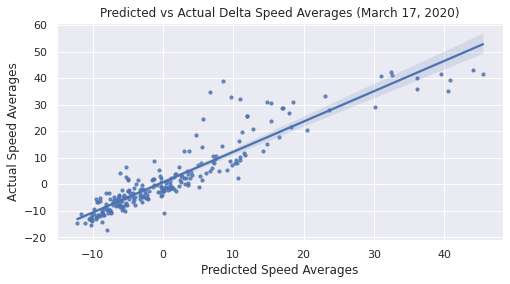

In [45]:
# Evaluate model on the 17th
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset((time_series - np.array(speeds_daily)).iloc[:, 11:17], 5, 0)
res = reg_delta.score(X_delta_train, y_delta_train)
print('Score:', res)

# Plot Scatter: 
sns.regplot(x=reg.predict(X_delta_train), y=y_delta_train, scatter_kws={'s':10});
plt.title('Predicted vs Actual Delta Speed Averages (March 17, 2020)');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');

### Does the Pre-Lockdown Model Predict After the Change Point?

The temporal plot above showing performance over time suggests a partial recovery. To see, evaluate the original, naive model on all post-lockdown data. 

Score: 0.9014738674628209


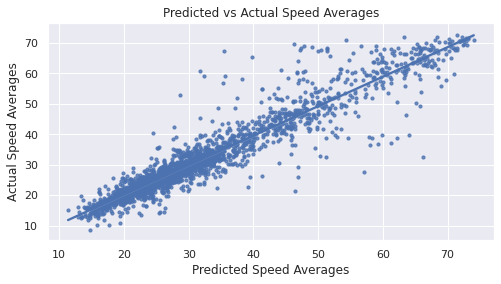

In [46]:
X_train_og, y_train_og, X_val_og, y_val_og = time_series_to_dataset(time_series.iloc[:, 13:], 5, 0)
score_og_post = reg.score(X_train_og, y_train_og)
print('Score:', score_og_post)

# Plot Scatter: 
sns.regplot(x=reg.predict(X_train_og), y=y_train_og, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');

### Naively Retrain Model With Post-Lockdown Data

Train a linear model and evaluate on post-lockdown data

Score: 0.89936875763517


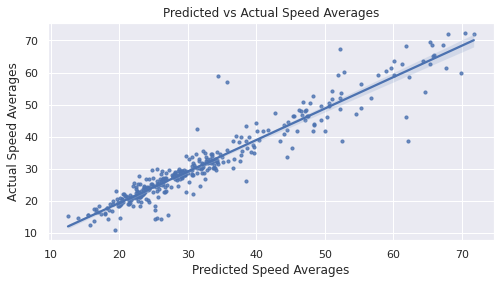

In [47]:
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series.iloc[:, 13:], 5, 2)
reg = LinearRegression().fit(X_train, y_train)
score_post = reg.score(X_val, y_val)
print('Score:', score_post)

# Plot Scatter: 
sns.regplot(x=reg.predict(X_val), y=y_val, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');

### Ignoring the Change Point

The lower r^2 score is the outcome of training on both before and after the change point.

Score: 0.8843433608623492


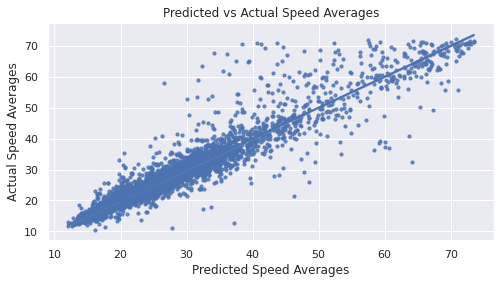

In [48]:
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series, 5, 5)
reg = LinearRegression().fit(X_train, y_train)
res = reg.score(X_val, y_val)
print('Score:', res)

# Plot Scatter: 
sns.regplot(x=reg.predict(X_train), y=y_train, scatter_kws={'s':10});
plt.title('Predicted vs Actual Speed Averages');
plt.xlabel('Predicted Speed Averages');
plt.ylabel('Actual Speed Averages');